# Olympic Athletes: Medal Prediction
## Machine Learning Project 3

**Objective:** Build a classification model to predict whether an athlete will win a medal (Gold, Silver, Bronze) or not.

**Dataset:** athlete_events.csv - Historical Olympic Games data (Athens 1896 to Rio 2016)

## 1. Import Libraries

In [2]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Metrics
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
    roc_curve
)

# Handle imbalanced data
from imblearn.over_sampling import SMOTE

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load and Initial Exploration

In [26]:
# Load data
df = pd.read_csv('athlete_events.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nMemory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
df.head()

Dataset shape: (271116, 15)

Memory usage: 158.85 MB


,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


In [28]:
# Basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271116 entries, 0 to 271115
Data columns (total 15 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      271116 non-null  int64  
 1   Name    271116 non-null  object 
 2   Sex     271116 non-null  object 
 3   Age     261642 non-null  float64
 4   Height  210945 non-null  float64
 5   Weight  208241 non-null  float64
 6   Team    271116 non-null  object 
 7   NOC     271116 non-null  object 
 8   Games   271116 non-null  object 
 9   Year    271116 non-null  int64  
 10  Season  271116 non-null  object 
 11  City    271116 non-null  object 
 12  Sport   271116 non-null  object 
 13  Event   271116 non-null  object 
 14  Medal   39783 non-null   object 
dtypes: float64(3), int64(2), object(10)
memory usage: 31.0+ MB


In [30]:
# Statistical summary
df.describe()

,ID,Age,Height,Weight,Year
count,271116.000000,261642.000000,210945.000000,208241.000000,271116.000000
mean,68248.954396,25.556898,175.338970,70.702393,1978.378480
std,39022.286345,6.393561,10.518462,14.348020,29.877632
min,1.000000,10.000000,127.000000,25.000000,1896.000000
25%,34643.000000,21.000000,168.000000,60.000000,1960.000000
50%,68205.000000,24.000000,175.000000,70.000000,1988.000000
75%,102097.250000,28.000000,183.000000,79.000000,2002.000000
max,135571.000000,97.000000,226.000000,214.000000,2016.000000


## 3. Exploratory Data Analysis (EDA)

### 3.1 Target Variable Analysis

Medal Distribution:
Medal
Gold      13372
Bronze    13295
Silver    13116
Name: count, dtype: int64

Medal Rate: 100.00%


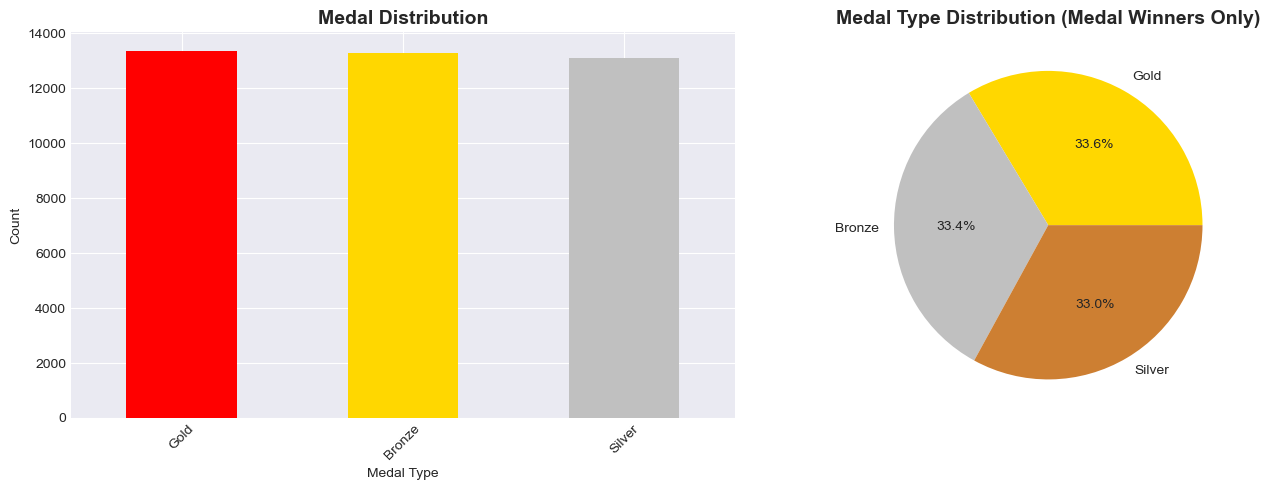

In [32]:
# Medal distribution
medal_counts = df['Medal'].value_counts()
print("Medal Distribution:")
print(medal_counts)
print(f"\nMedal Rate: {(len(df) - medal_counts.get('NA', 0)) / len(df) * 100:.2f}%")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
medal_counts.plot(kind='bar', ax=axes[0], color=['red', 'gold', 'silver', 'gray'])
axes[0].set_title('Medal Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Medal Type')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

# Pie chart (excluding NA)
medal_only = df[df['Medal'].notna()]['Medal'].value_counts()
axes[1].pie(medal_only, labels=medal_only.index, autopct='%1.1f%%', 
           colors=['gold', 'silver', '#CD7F32'])
axes[1].set_title('Medal Type Distribution (Medal Winners Only)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# This is highly imbalanced - most athletes don't win medals

### 3.2 Missing Values Analysis

Missing Values Summary:
        Missing Count  Percentage
Medal          231333       85.33
Weight          62875       23.19
Height          60171       22.19
Age              9474        3.49


<Figure size 1000x600 with 0 Axes>

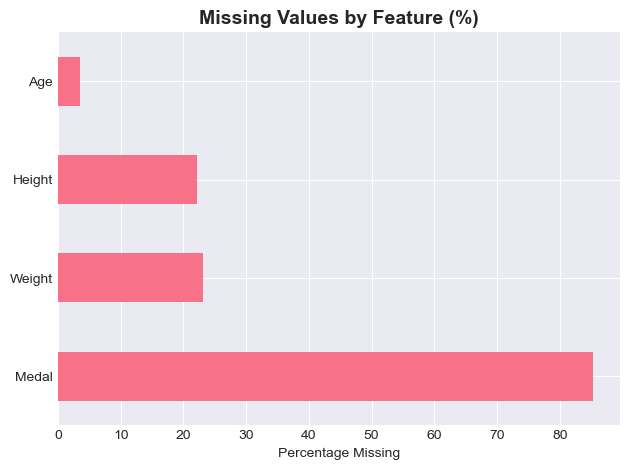

In [34]:
# Missing values
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Percentage': missing_pct
}).sort_values('Percentage', ascending=False)

print("Missing Values Summary:")
print(missing_df[missing_df['Missing Count'] > 0])

# Visualize
plt.figure(figsize=(10, 6))
missing_df[missing_df['Missing Count'] > 0].plot(kind='barh', y='Percentage', legend=False)
plt.title('Missing Values by Feature (%)', fontsize=14, fontweight='bold')
plt.xlabel('Percentage Missing')
plt.tight_layout()
plt.show()

### 3.3 Numerical Features Analysis

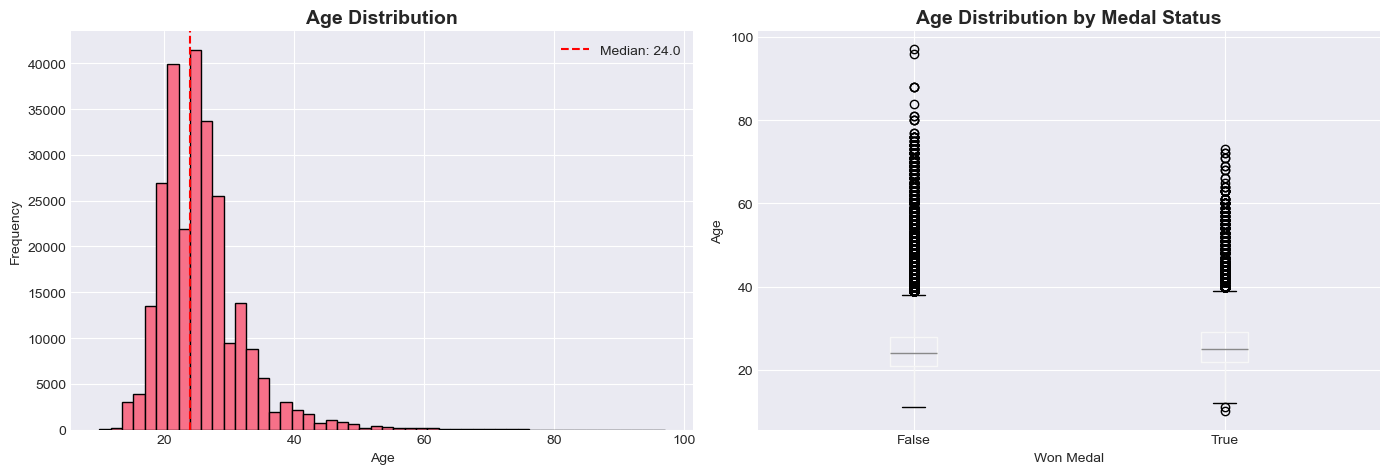

Age Statistics:
Mean: 25.56
Median: 24.00
Range: 10 - 97


In [36]:
# Age distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Overall age distribution
df['Age'].hist(bins=50, ax=axes[0], edgecolor='black')
axes[0].set_title('Age Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Frequency')
axes[0].axvline(df['Age'].median(), color='red', linestyle='--', label=f'Median: {df["Age"].median()}')
axes[0].legend()

# Age by medal status
df_plot = df.copy()
df_plot['Has_Medal'] = df_plot['Medal'].notna() & (df_plot['Medal'] != 'NA')
df_plot[df_plot['Age'].notna()].boxplot(column='Age', by='Has_Medal', ax=axes[1])
axes[1].set_title('Age Distribution by Medal Status', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Won Medal')
axes[1].set_ylabel('Age')
plt.suptitle('')

plt.tight_layout()
plt.show()

print(f"Age Statistics:")
print(f"Mean: {df['Age'].mean():.2f}")
print(f"Median: {df['Age'].median():.2f}")
print(f"Range: {df['Age'].min():.0f} - {df['Age'].max():.0f}")

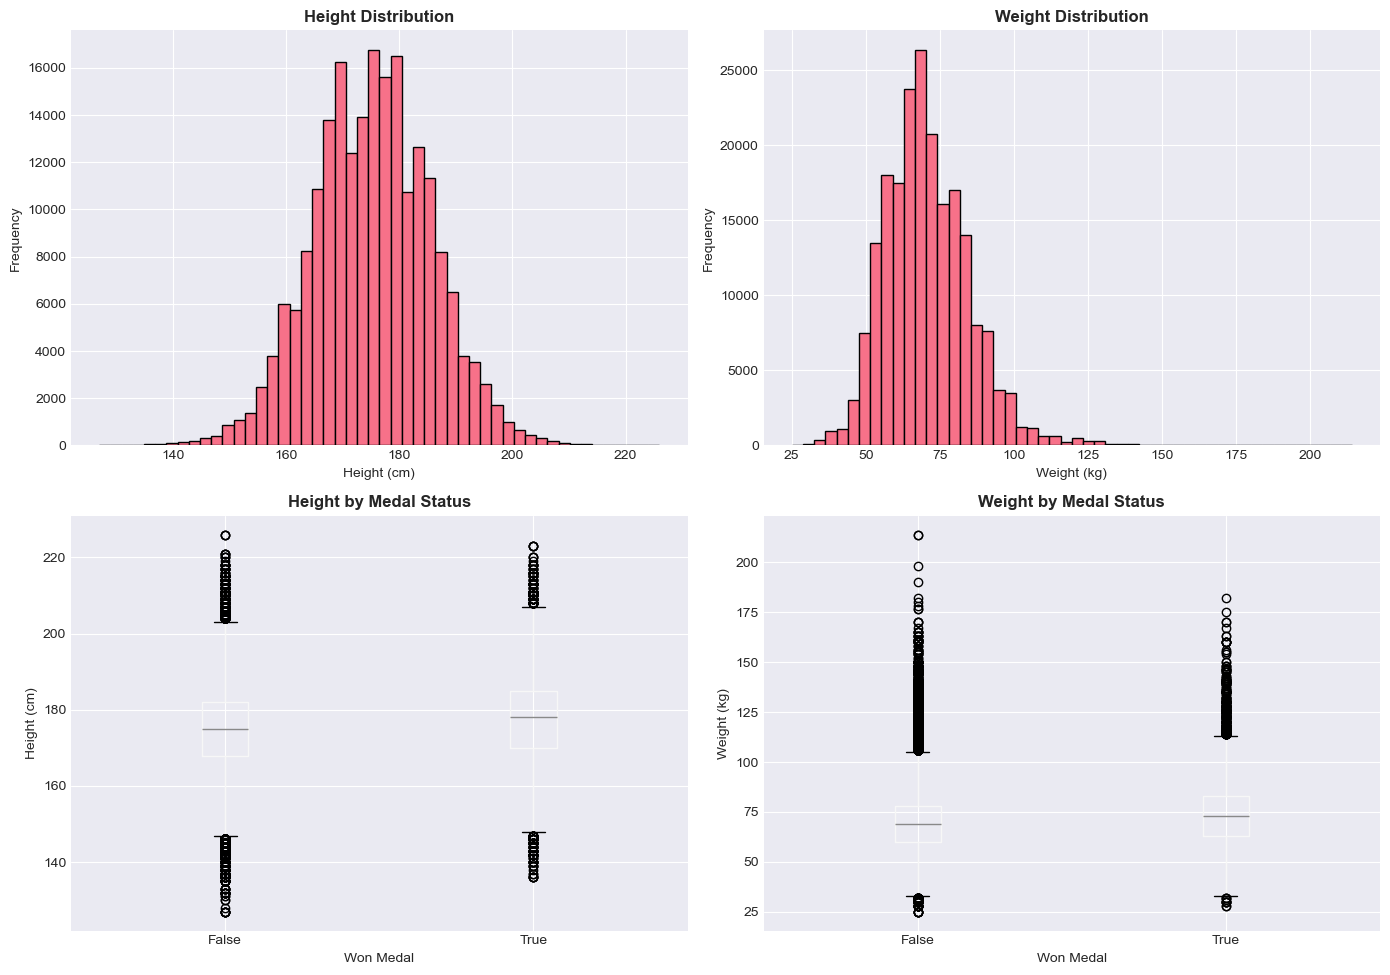

In [38]:
# Height and Weight analysis
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Height distribution
df['Height'].hist(bins=50, ax=axes[0, 0], edgecolor='black')
axes[0, 0].set_title('Height Distribution', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Height (cm)')
axes[0, 0].set_ylabel('Frequency')

# Weight distribution
df['Weight'].hist(bins=50, ax=axes[0, 1], edgecolor='black')
axes[0, 1].set_title('Weight Distribution', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Weight (kg)')
axes[0, 1].set_ylabel('Frequency')

# Height by medal
df_plot[df_plot['Height'].notna()].boxplot(column='Height', by='Has_Medal', ax=axes[1, 0])
axes[1, 0].set_title('Height by Medal Status', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Won Medal')
axes[1, 0].set_ylabel('Height (cm)')

# Weight by medal
df_plot[df_plot['Weight'].notna()].boxplot(column='Weight', by='Has_Medal', ax=axes[1, 1])
axes[1, 1].set_title('Weight by Medal Status', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Won Medal')
axes[1, 1].set_ylabel('Weight (kg)')

plt.suptitle('')
plt.tight_layout()
plt.show()

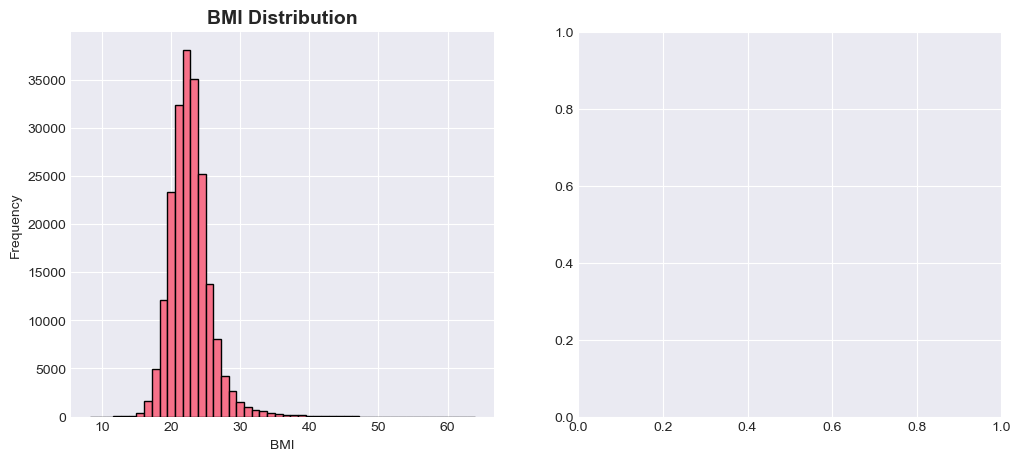

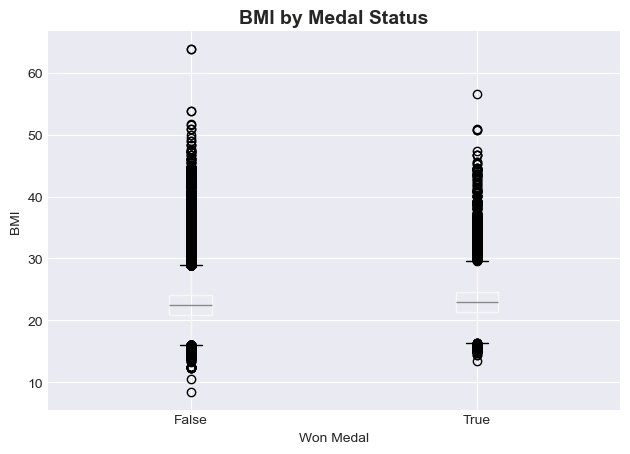

In [40]:
# BMI calculation
df['BMI'] = df['Weight'] / ((df['Height'] / 100) ** 2)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
df['BMI'].hist(bins=50, edgecolor='black')
plt.title('BMI Distribution', fontsize=14, fontweight='bold')
plt.xlabel('BMI')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
df_plot['BMI'] = df_plot['Weight'] / ((df_plot['Height'] / 100) ** 2)
df_plot[df_plot['BMI'].notna()].boxplot(column='BMI', by='Has_Medal')
plt.title('BMI by Medal Status', fontsize=14, fontweight='bold')
plt.xlabel('Won Medal')
plt.ylabel('BMI')
plt.suptitle('')

plt.tight_layout()
plt.show()

### 3.4 Categorical Features Analysis

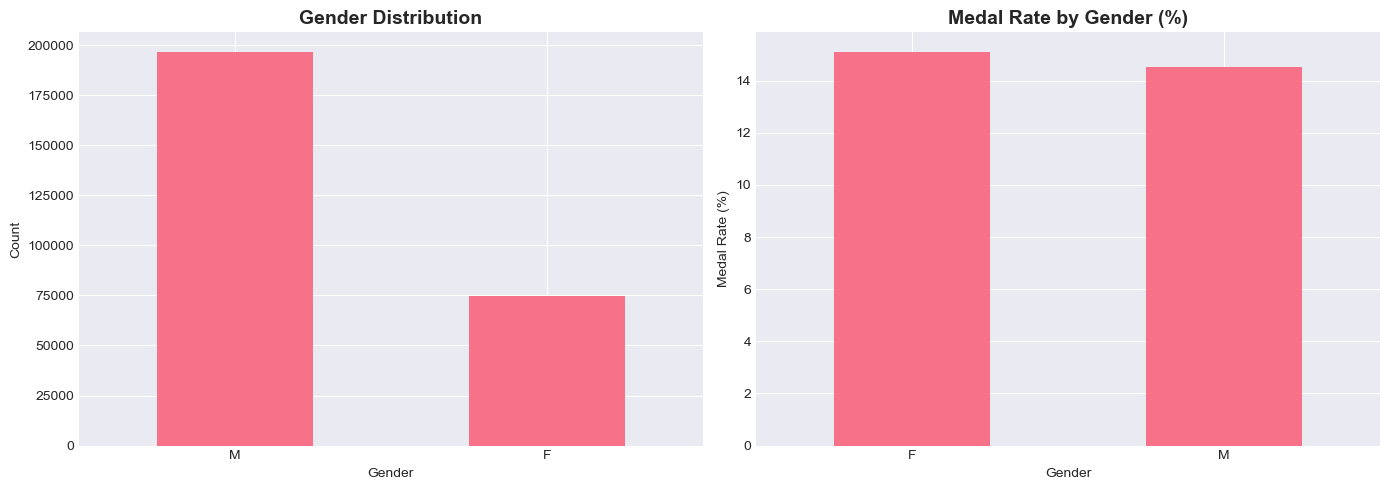


Medal Rate by Gender:
Sex
F    15.100239
M    14.512142
Name: Medal, dtype: float64


In [42]:
# Gender analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gender distribution
df['Sex'].value_counts().plot(kind='bar', ax=axes[0])
axes[0].set_title('Gender Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Gender')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=0)

# Medal rate by gender
gender_medal = df.groupby('Sex')['Medal'].apply(lambda x: (x.notna() & (x != 'NA')).sum() / len(x) * 100)
gender_medal.plot(kind='bar', ax=axes[1])
axes[1].set_title('Medal Rate by Gender (%)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Gender')
axes[1].set_ylabel('Medal Rate (%)')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

print("\nMedal Rate by Gender:")
print(gender_medal)

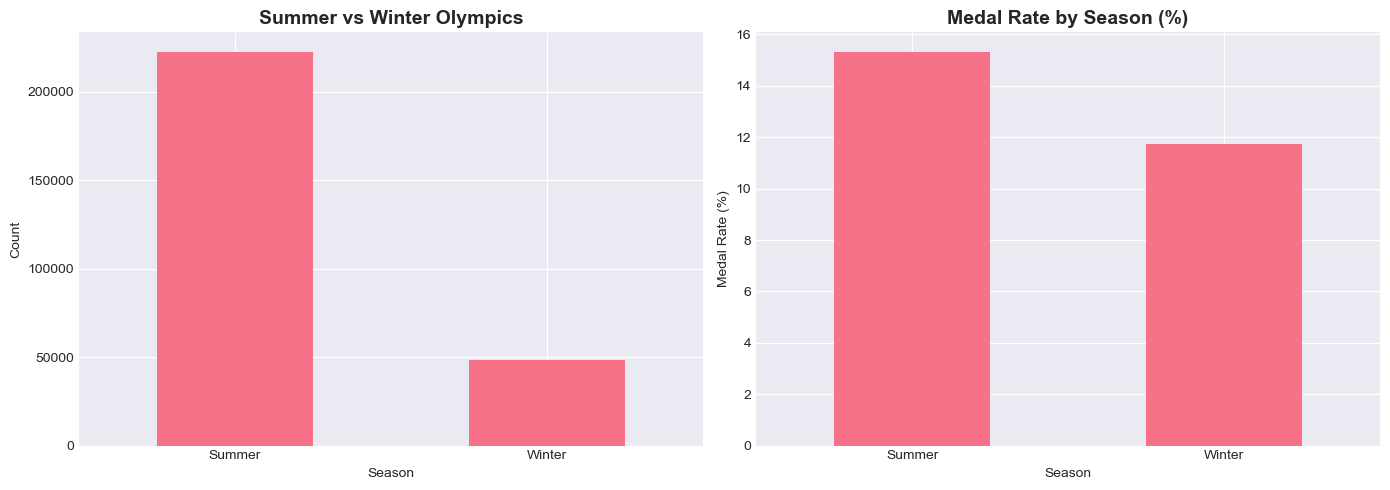

In [44]:
# Season analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Season distribution
df['Season'].value_counts().plot(kind='bar', ax=axes[0])
axes[0].set_title('Summer vs Winter Olympics', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Season')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=0)

# Medal rate by season
season_medal = df.groupby('Season')['Medal'].apply(lambda x: (x.notna() & (x != 'NA')).sum() / len(x) * 100)
season_medal.plot(kind='bar', ax=axes[1])
axes[1].set_title('Medal Rate by Season (%)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Season')
axes[1].set_ylabel('Medal Rate (%)')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

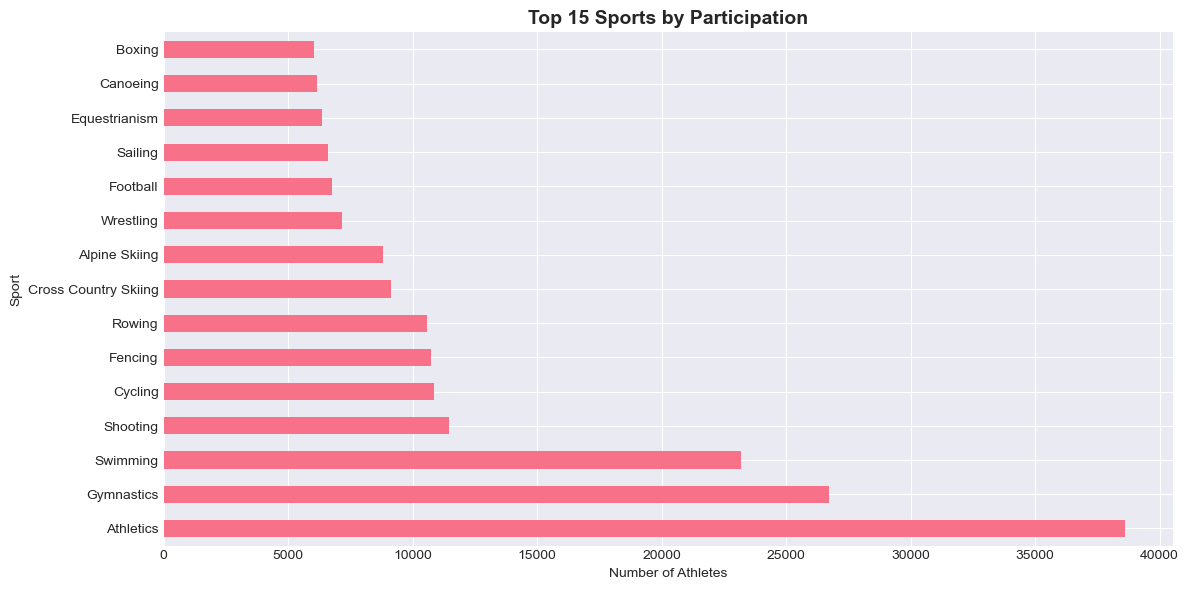

In [46]:
# Top sports by participation
top_sports = df['Sport'].value_counts().head(15)

plt.figure(figsize=(12, 6))
top_sports.plot(kind='barh')
plt.title('Top 15 Sports by Participation', fontsize=14, fontweight='bold')
plt.xlabel('Number of Athletes')
plt.ylabel('Sport')
plt.tight_layout()
plt.show()

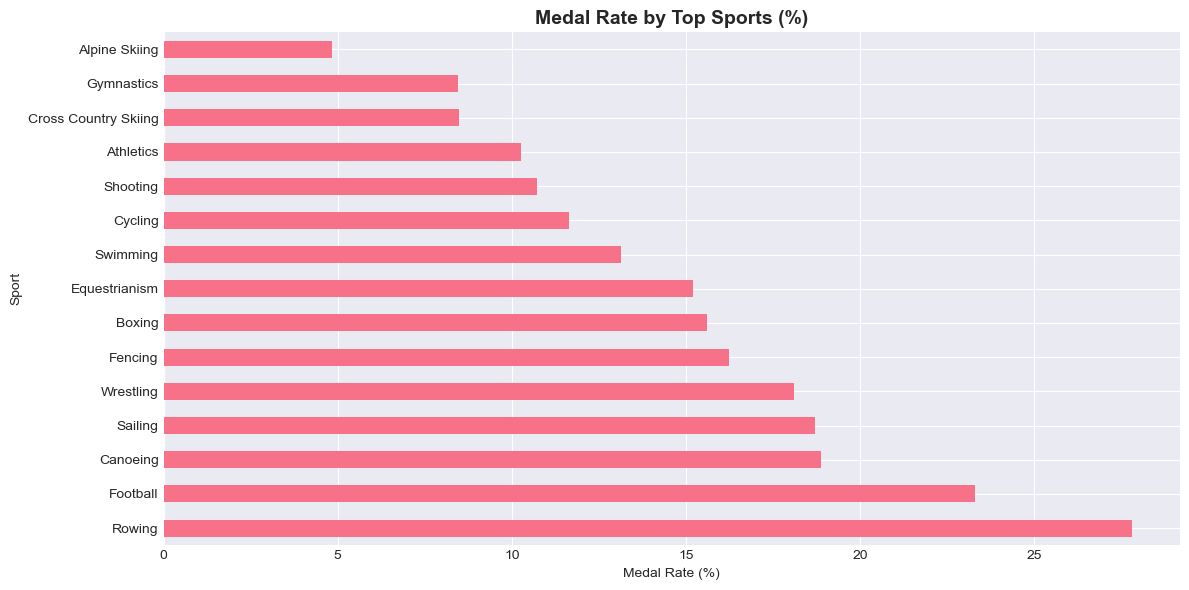

In [48]:
# Medal rate by top sports
medal_rate_by_sport = df[df['Sport'].isin(top_sports.index)].groupby('Sport')['Medal'].apply(
    lambda x: (x.notna() & (x != 'NA')).sum() / len(x) * 100
).sort_values(ascending=False)

plt.figure(figsize=(12, 6))
medal_rate_by_sport.plot(kind='barh')
plt.title('Medal Rate by Top Sports (%)', fontsize=14, fontweight='bold')
plt.xlabel('Medal Rate (%)')
plt.ylabel('Sport')
plt.tight_layout()
plt.show()

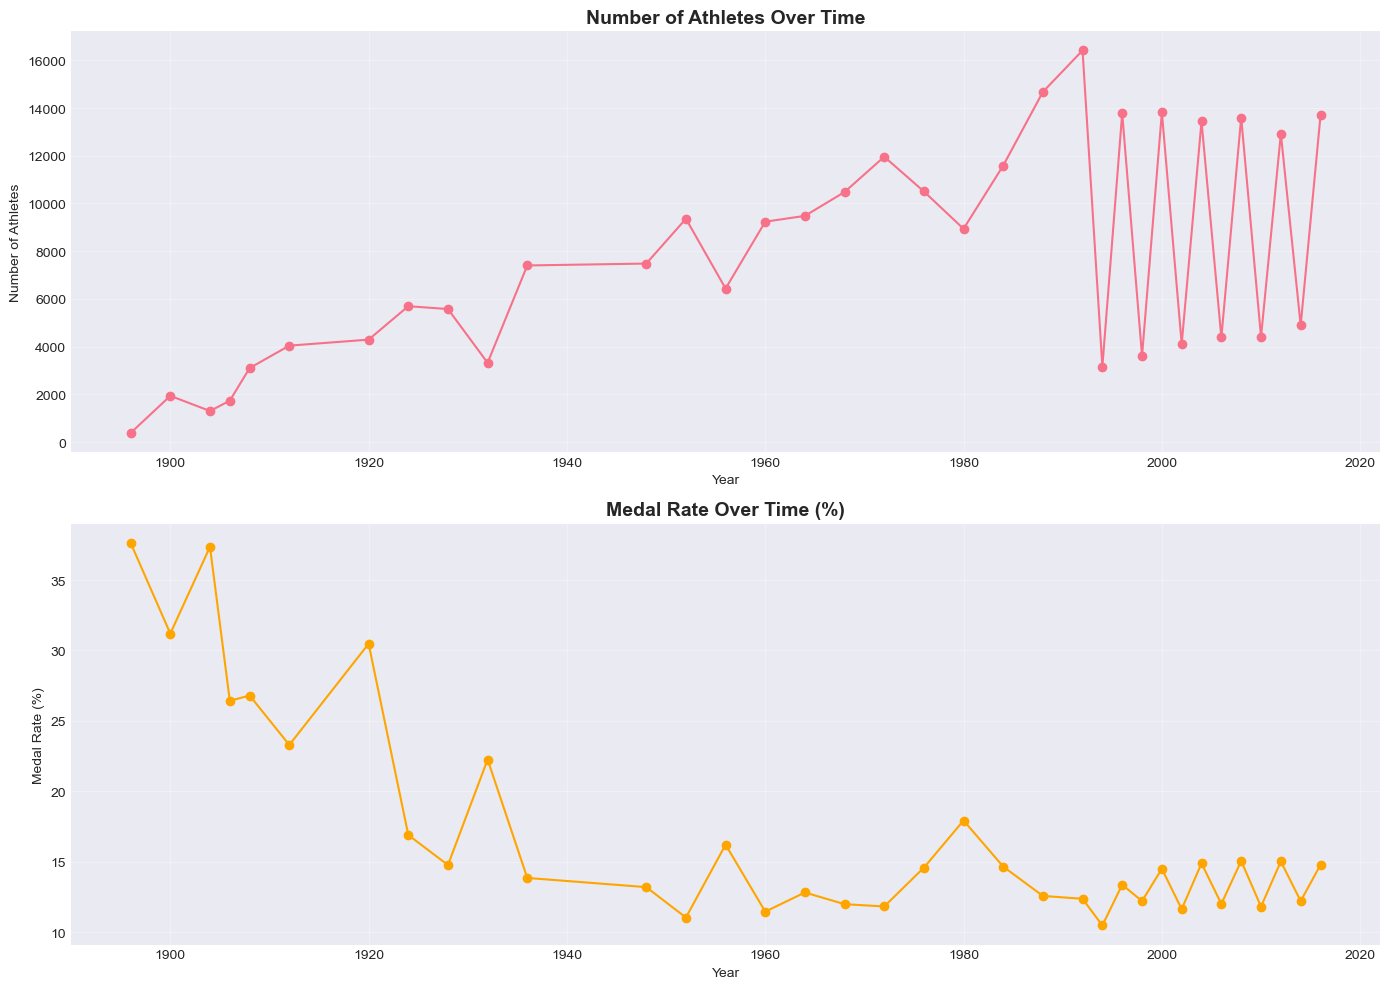

In [50]:
# Year trends
year_stats = df.groupby('Year').agg({
    'ID': 'count',
    'Medal': lambda x: (x.notna() & (x != 'NA')).sum()
}).rename(columns={'ID': 'Athletes', 'Medal': 'Medals'})
year_stats['Medal_Rate'] = (year_stats['Medals'] / year_stats['Athletes']) * 100

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Athletes over time
year_stats['Athletes'].plot(ax=axes[0], marker='o')
axes[0].set_title('Number of Athletes Over Time', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Number of Athletes')
axes[0].grid(True, alpha=0.3)

# Medal rate over time
year_stats['Medal_Rate'].plot(ax=axes[1], marker='o', color='orange')
axes[1].set_title('Medal Rate Over Time (%)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Medal Rate (%)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 3.5 Correlation Analysis

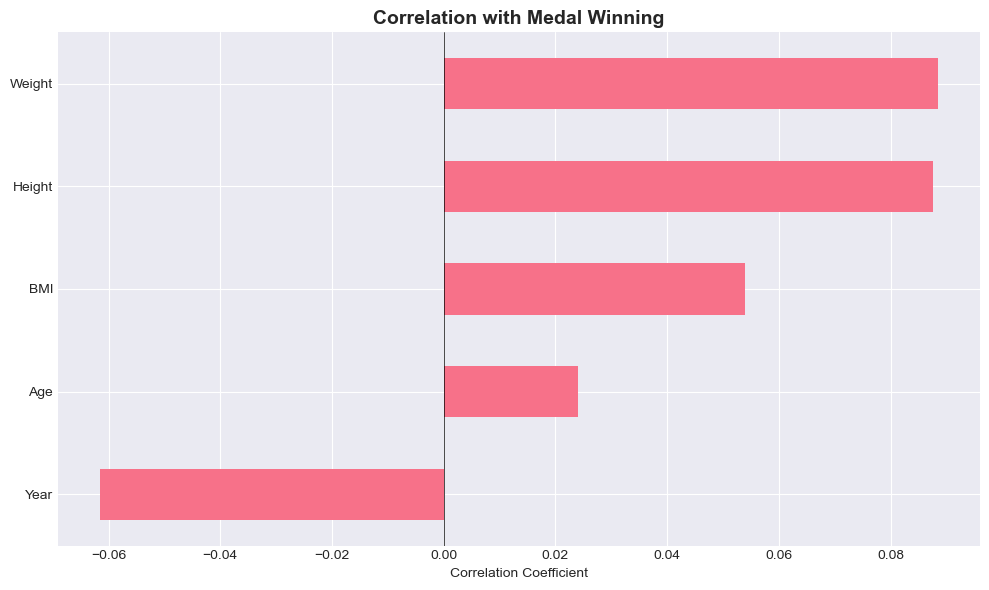

Correlation with Medal Winning:
Year     -0.061552
Age       0.024126
BMI       0.053919
Height    0.087532
Weight    0.088510
Name: Has_Medal, dtype: float64


In [52]:
# Correlation of numerical features with medal winning
df_corr = df.copy()
df_corr['Has_Medal'] = (df_corr['Medal'].notna() & (df_corr['Medal'] != 'NA')).astype(int)

numerical_cols = ['Age', 'Height', 'Weight', 'BMI', 'Year']
corr_with_medal = df_corr[numerical_cols + ['Has_Medal']].corr()['Has_Medal'].drop('Has_Medal').sort_values()

plt.figure(figsize=(10, 6))
corr_with_medal.plot(kind='barh')
plt.title('Correlation with Medal Winning', fontsize=14, fontweight='bold')
plt.xlabel('Correlation Coefficient')
plt.axvline(0, color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.show()

print("Correlation with Medal Winning:")
print(corr_with_medal)

## 4. Data Preprocessing

### 4.1 Create Target Variable

In [54]:
# Create binary target: 1 = won medal, 0 = no medal
df['Won_Medal'] = ((df['Medal'].notna()) & (df['Medal'] != 'NA')).astype(int)

print("Target Variable Distribution:")
print(df['Won_Medal'].value_counts())
print(f"\nClass Balance: {df['Won_Medal'].value_counts(normalize=True) * 100}")

Target Variable Distribution:
Won_Medal
0    231333
1     39783
Name: count, dtype: int64

Class Balance: Won_Medal
0    85.326207
1    14.673793
Name: proportion, dtype: float64


### 4.2 Feature Engineering

In [56]:
# Create new features
df_processed = df.copy()

# 1. Age groups
df_processed['Age_Group'] = pd.cut(df_processed['Age'], 
                                     bins=[0, 18, 25, 30, 35, 100],
                                     labels=['Under_18', '18-25', '26-30', '31-35', 'Over_35'])

# 2. Years since first Olympics
first_year = df_processed['Year'].min()
df_processed['Years_Since_First_Olympics'] = df_processed['Year'] - first_year

# 3. Experience (count of previous participations by athlete)
athlete_experience = df_processed.groupby('ID').cumcount()
df_processed['Experience'] = athlete_experience

# 4. Historical medal count per athlete
athlete_medals = df_processed.groupby('ID')['Won_Medal'].cumsum() - df_processed['Won_Medal']
df_processed['Previous_Medals'] = athlete_medals

# 5. Country medal rate (historical performance)
noc_medal_rate = df_processed.groupby('NOC')['Won_Medal'].transform('mean')
df_processed['NOC_Medal_Rate'] = noc_medal_rate

# 6. Sport medal rate
sport_medal_rate = df_processed.groupby('Sport')['Won_Medal'].transform('mean')
df_processed['Sport_Medal_Rate'] = sport_medal_rate

# 7. Event medal rate
event_medal_rate = df_processed.groupby('Event')['Won_Medal'].transform('mean')
df_processed['Event_Medal_Rate'] = event_medal_rate

# 8. Team size in that event
team_size = df_processed.groupby(['Year', 'Event', 'Team'])['ID'].transform('count')
df_processed['Team_Size'] = team_size

# 9. Age deviation from sport average
sport_avg_age = df_processed.groupby('Sport')['Age'].transform('mean')
df_processed['Age_vs_Sport_Avg'] = df_processed['Age'] - sport_avg_age

# 10. Height/Weight ratios
df_processed['Height_Weight_Ratio'] = df_processed['Height'] / df_processed['Weight']

print("New features created:")
print(df_processed[['Age_Group', 'Years_Since_First_Olympics', 'Experience', 
                     'Previous_Medals', 'NOC_Medal_Rate', 'Sport_Medal_Rate']].head())

New features created:
  Age_Group  Years_Since_First_Olympics  Experience  Previous_Medals  \
0     18-25                          96           0                0   
1     18-25                         116           0                0   
2     18-25                          24           0                0   
3     31-35                           4           0                0   
4     18-25                          92           0                0   

   NOC_Medal_Rate  Sport_Medal_Rate  
0        0.192375          0.238095  
1        0.192375          0.143909  
2        0.167227          0.232913  
3        0.167227          0.676471  
4        0.178113          0.103332  


### 4.3 Handle Missing Values

In [58]:
# Check missing values in processed data
print("Missing values after feature engineering:")
print(df_processed.isnull().sum()[df_processed.isnull().sum() > 0])

# Strategy:
# - Age: median imputation by Sport
# - Height/Weight: median imputation by Sport and Sex
# - Derived features (BMI, etc.): will be imputed after

# Impute Age
df_processed['Age'] = df_processed.groupby('Sport')['Age'].transform(
    lambda x: x.fillna(x.median())
)
# Fill any remaining with overall median
df_processed['Age'].fillna(df_processed['Age'].median(), inplace=True)

# Impute Height
df_processed['Height'] = df_processed.groupby(['Sport', 'Sex'])['Height'].transform(
    lambda x: x.fillna(x.median())
)
df_processed['Height'].fillna(df_processed['Height'].median(), inplace=True)

# Impute Weight
df_processed['Weight'] = df_processed.groupby(['Sport', 'Sex'])['Weight'].transform(
    lambda x: x.fillna(x.median())
)
df_processed['Weight'].fillna(df_processed['Weight'].median(), inplace=True)

# Recalculate derived features
df_processed['BMI'] = df_processed['Weight'] / ((df_processed['Height'] / 100) ** 2)
df_processed['Height_Weight_Ratio'] = df_processed['Height'] / df_processed['Weight']

sport_avg_age = df_processed.groupby('Sport')['Age'].transform('mean')
df_processed['Age_vs_Sport_Avg'] = df_processed['Age'] - sport_avg_age

# Fill Age_Group
df_processed['Age_Group'] = pd.cut(df_processed['Age'], 
                                     bins=[0, 18, 25, 30, 35, 100],
                                     labels=['Under_18', '18-25', '26-30', '31-35', 'Over_35'])

print("\nMissing values after imputation:")
print(df_processed.isnull().sum()[df_processed.isnull().sum() > 0])

Missing values after feature engineering:
Age                      9474
Height                  60171
Weight                  62875
Medal                  231333
BMI                     64263
Age_Group                9474
Age_vs_Sport_Avg         9474
Height_Weight_Ratio     64263
dtype: int64

Missing values after imputation:
Medal    231333
dtype: int64


### 4.4 Encode Categorical Variables

In [60]:
# Select features for modeling
feature_cols = [
    # Numerical
    'Age', 'Height', 'Weight', 'BMI', 'Height_Weight_Ratio',
    'Year', 'Years_Since_First_Olympics',
    'Experience', 'Previous_Medals', 'Team_Size',
    'NOC_Medal_Rate', 'Sport_Medal_Rate', 'Event_Medal_Rate',
    'Age_vs_Sport_Avg',
    # Categorical
    'Sex', 'Season', 'Age_Group'
]

# For high-cardinality categoricals, we'll use target encoding
# For low-cardinality, we'll use one-hot encoding

X = df_processed[feature_cols].copy()
y = df_processed['Won_Medal'].copy()

# One-hot encode low cardinality features
X = pd.get_dummies(X, columns=['Sex', 'Season', 'Age_Group'], drop_first=True)

print(f"Final feature matrix shape: {X.shape}")
print(f"\nFeatures: {list(X.columns)}")

Final feature matrix shape: (271116, 20)

Features: ['Age', 'Height', 'Weight', 'BMI', 'Height_Weight_Ratio', 'Year', 'Years_Since_First_Olympics', 'Experience', 'Previous_Medals', 'Team_Size', 'NOC_Medal_Rate', 'Sport_Medal_Rate', 'Event_Medal_Rate', 'Age_vs_Sport_Avg', 'Sex_M', 'Season_Winter', 'Age_Group_18-25', 'Age_Group_26-30', 'Age_Group_31-35', 'Age_Group_Over_35']


### 4.5 Train-Test Split

In [62]:
# Split data - stratified to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"\nTraining set class distribution:")
print(y_train.value_counts(normalize=True) * 100)
print(f"\nTest set class distribution:")
print(y_test.value_counts(normalize=True) * 100)

Training set size: (216892, 20)
Test set size: (54224, 20)

Training set class distribution:
Won_Medal
0    85.326338
1    14.673662
Name: proportion, dtype: float64

Test set class distribution:
Won_Medal
0    85.325686
1    14.674314
Name: proportion, dtype: float64


### 4.6 Feature Scaling

In [64]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for interpretability
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("Features scaled successfully!")
print(f"\nSample of scaled features:")
print(X_train_scaled.head())

Features scaled successfully!

Sample of scaled features:
             Age    Height    Weight       BMI  Height_Weight_Ratio      Year  \
40835  -0.876326 -0.767073 -1.362518 -1.518212             1.736105  1.259840   
86173   0.690996  0.147133  1.280747  1.926536            -1.434856  0.858295   
249279 -0.876326 -0.563916 -1.286996 -1.552703             1.676808 -0.078644   
200841 -0.406129 -1.376543  0.298963  2.107444            -1.028001  1.259840   
196710 -0.406129  0.959760  0.298963 -0.358156            -0.188578 -1.550975   

        Years_Since_First_Olympics  Experience  Previous_Medals  Team_Size  \
40835                     1.259840   -0.554225        -0.274966  -0.218515   
86173                     0.858295   -0.554225        -0.274966   1.599966   
249279                   -0.078644   -0.554225        -0.274966  -0.305109   
200841                    1.259840   -0.181252         1.115941  -0.391703   
196710                   -1.550975   -0.554225        -0.274966  

### 4.7 Handle Class Imbalance with SMOTE

In [66]:
# Apply SMOTE to training data only
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print("Class distribution after SMOTE:")
print(pd.Series(y_train_balanced).value_counts())
print(f"\nPercentage: {pd.Series(y_train_balanced).value_counts(normalize=True) * 100}")

print(f"\nTraining set size after SMOTE: {X_train_balanced.shape}")

Class distribution after SMOTE:
Won_Medal
0    185066
1    185066
Name: count, dtype: int64

Percentage: Won_Medal
0    50.0
1    50.0
Name: proportion, dtype: float64

Training set size after SMOTE: (370132, 20)


## 5. Model Training and Evaluation

### 5.1 Baseline Models

In [68]:
# Define models to test
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss')
}

# Train and evaluate each model
results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train
    model.fit(X_train_balanced, y_train_balanced)
    
    # Predict
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
    auc = roc_auc_score(y_test, y_pred_proba)
    
    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC-ROC': auc,
        'model': model,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"AUC-ROC: {auc:.4f}")

print("\n" + "="*50)
print("All models trained successfully!")


Training Logistic Regression...
Accuracy: 0.7400
Precision: 0.3263
Recall: 0.7246
F1-Score: 0.4500
AUC-ROC: 0.8126

Training Decision Tree...
Accuracy: 0.8512
Precision: 0.4937
Recall: 0.5616
F1-Score: 0.5255
AUC-ROC: 0.7314

Training Random Forest...
Accuracy: 0.8938
Precision: 0.6782
Recall: 0.5258
F1-Score: 0.5924
AUC-ROC: 0.8827

Training Gradient Boosting...
Accuracy: 0.8015
Precision: 0.3887
Recall: 0.6163
F1-Score: 0.4767
AUC-ROC: 0.8220

Training XGBoost...
Accuracy: 0.8781
Precision: 0.6234
Recall: 0.4269
F1-Score: 0.5068
AUC-ROC: 0.8522

All models trained successfully!



Model Comparison:
                     Accuracy  Precision    Recall  F1-Score   AUC-ROC
Random Forest        0.893811   0.678230  0.525826  0.592383  0.882728
Decision Tree        0.851154   0.493703  0.561644  0.525487  0.731425
XGBoost              0.878061   0.623417  0.426920  0.506788  0.852183
Gradient Boosting    0.801472   0.388713  0.616313  0.476741  0.822001
Logistic Regression  0.740023   0.326279  0.724645  0.449959  0.812611


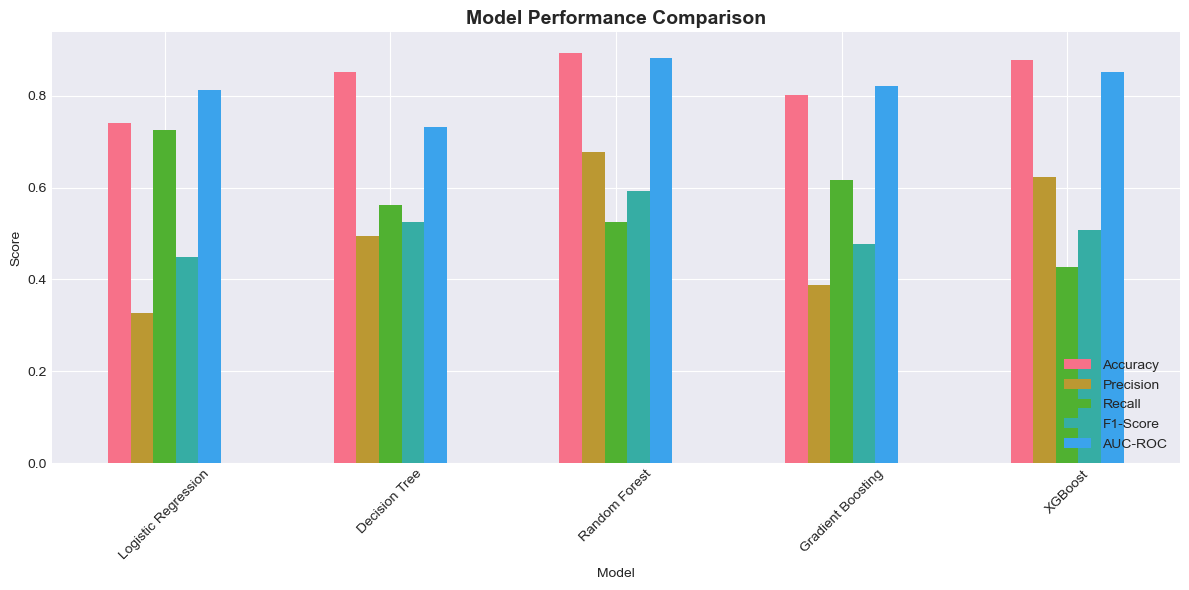

In [70]:
# Compare models
results_df = pd.DataFrame({
    name: {k: v for k, v in metrics.items() if k != 'model' and k != 'y_pred' and k != 'y_pred_proba'}
    for name, metrics in results.items()
}).T

print("\nModel Comparison:")
print(results_df.sort_values('F1-Score', ascending=False))

# Visualize
results_df.plot(kind='bar', figsize=(12, 6), rot=45)
plt.title('Model Performance Comparison', fontsize=14, fontweight='bold')
plt.ylabel('Score')
plt.xlabel('Model')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

### 5.2 Best Model Selection and Hyperparameter Tuning

In [ ]:
# Select best model based on F1-score (balance between precision and recall)
best_model_name = results_df['F1-Score'].idxmax()
print(f"Best performing model: {best_model_name}")
print(f"F1-Score: {results_df.loc[best_model_name, 'F1-Score']:.4f}")

# Hyperparameter tuning for best model (Random Forest as example)
print(f"\nPerforming hyperparameter tuning for {best_model_name}...")

if 'Random Forest' in best_model_name or 'XGBoost' in best_model_name:
    if 'Random Forest' in best_model_name:
        param_grid = {
            'n_estimators': [100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }
        base_model = RandomForestClassifier(random_state=42, n_jobs=-1)
    else:  # XGBoost
        param_grid = {
            'n_estimators': [100, 200],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.1],
            'subsample': [0.8, 1.0]
        }
        base_model = XGBClassifier(random_state=42, eval_metric='logloss')
    
    grid_search = GridSearchCV(
        base_model, param_grid, cv=3, scoring='f1',
        n_jobs=-1, verbose=1
    )
    
    # This may take some time
    grid_search.fit(X_train_balanced, y_train_balanced)
    
    print(f"\nBest parameters: {grid_search.best_params_}")
    print(f"Best CV F1-Score: {grid_search.best_score_:.4f}")
    
    # Use best model
    best_model = grid_search.best_estimator_
else:
    best_model = results[best_model_name]['model']

Best performing model: Random Forest
F1-Score: 0.5924

Performing hyperparameter tuning for Random Forest...
Fitting 3 folds for each of 24 candidates, totalling 72 fits


### 5.3 Final Model Evaluation


FINAL MODEL PERFORMANCE

Model: Random Forest

Classification Report:
              precision    recall  f1-score   support

    No Medal       0.92      0.96      0.94     46267
       Medal       0.69      0.53      0.60      7957

    accuracy                           0.90     54224
   macro avg       0.80      0.74      0.77     54224
weighted avg       0.89      0.90      0.89     54224



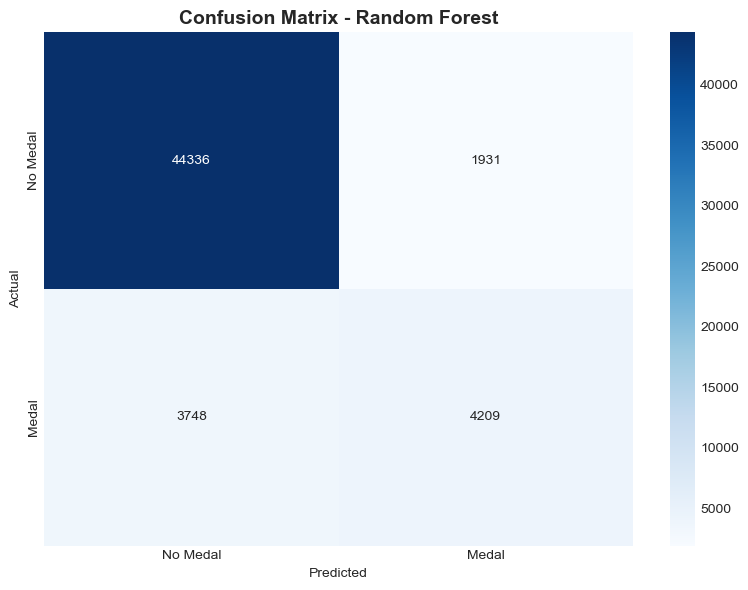


True Negatives: 44336
False Positives: 1931
False Negatives: 3748
True Positives: 4209


In [84]:
# Final predictions
y_pred_final = best_model.predict(X_test_scaled)
y_pred_proba_final = best_model.predict_proba(X_test_scaled)[:, 1]

# Detailed classification report
print("\n" + "="*50)
print("FINAL MODEL PERFORMANCE")
print("="*50)
print(f"\nModel: {best_model_name}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_final, target_names=['No Medal', 'Medal']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Medal', 'Medal'],
            yticklabels=['No Medal', 'Medal'])
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

print(f"\nTrue Negatives: {cm[0,0]}")
print(f"False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]}")
print(f"True Positives: {cm[1,1]}")

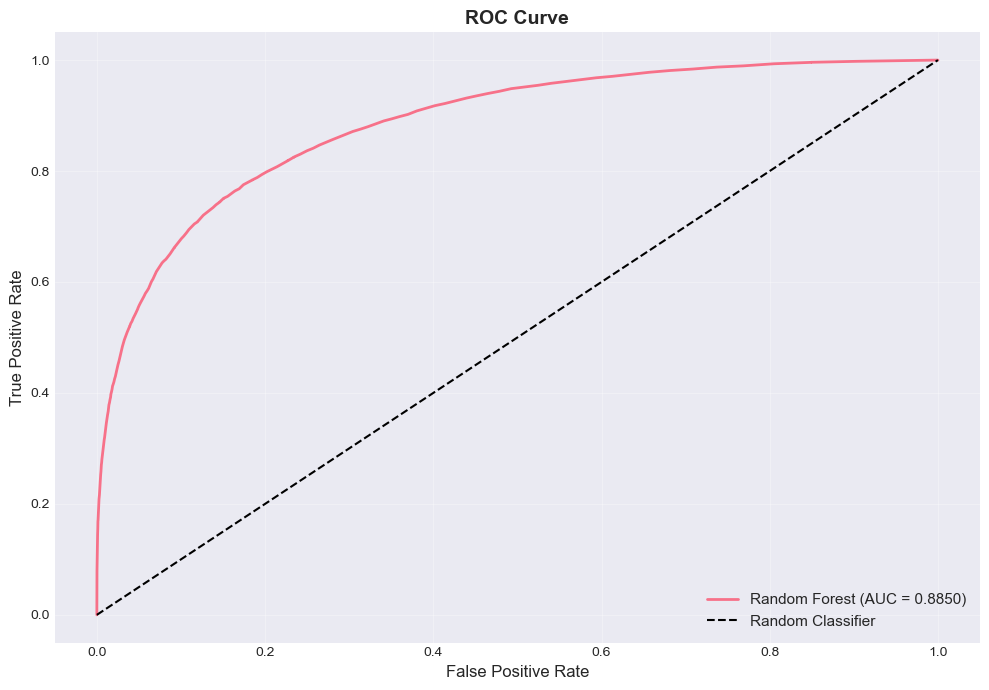

In [86]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_final)
auc_score = roc_auc_score(y_test, y_pred_proba_final)

plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, label=f'{best_model_name} (AUC = {auc_score:.4f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### 5.4 Feature Importance Analysis

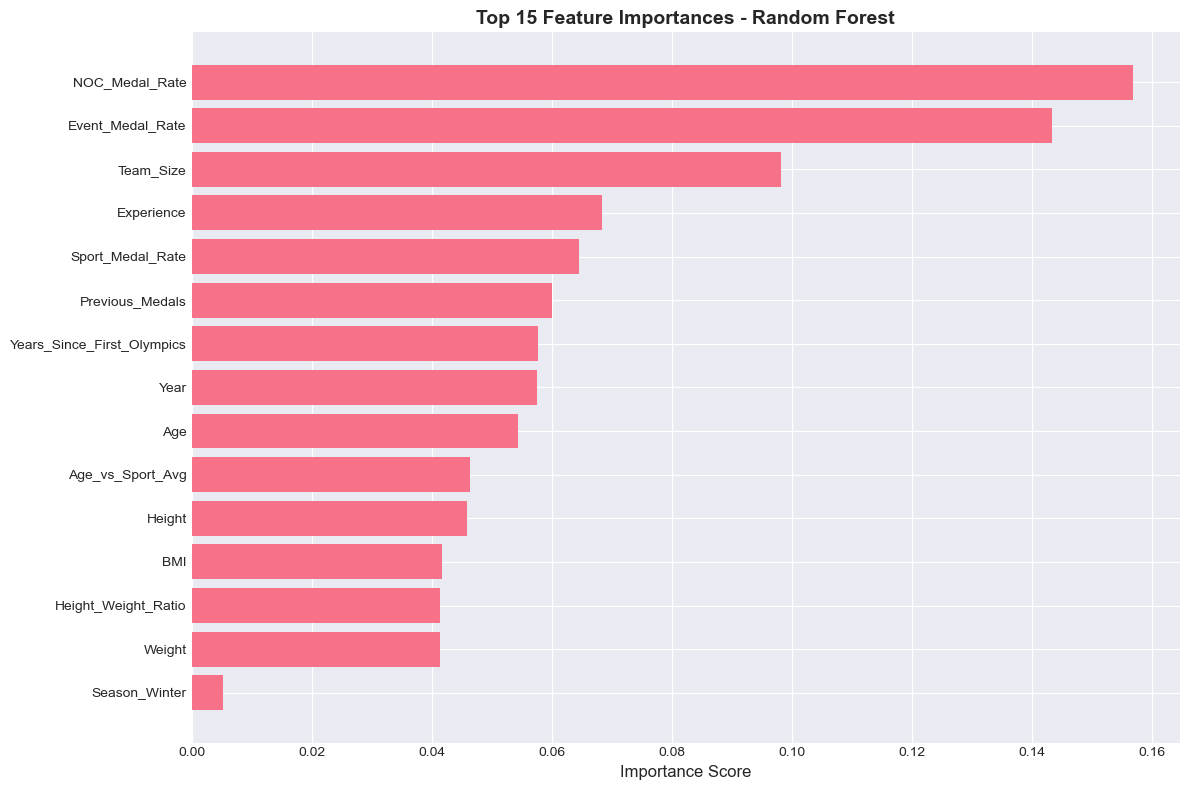


Top 10 Most Important Features:
                       Feature  Importance
10              NOC_Medal_Rate    0.156797
12            Event_Medal_Rate    0.143235
9                    Team_Size    0.098215
7                   Experience    0.068433
11            Sport_Medal_Rate    0.064489
8              Previous_Medals    0.060096
6   Years_Since_First_Olympics    0.057617
5                         Year    0.057611
0                          Age    0.054366
13            Age_vs_Sport_Avg    0.046344


In [89]:
# Feature importance (for tree-based models)
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    # Top 15 features
    top_features = feature_importance.head(15)
    
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(top_features)), top_features['Importance'])
    plt.yticks(range(len(top_features)), top_features['Feature'])
    plt.xlabel('Importance Score', fontsize=12)
    plt.title(f'Top 15 Feature Importances - {best_model_name}', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    print("\nTop 10 Most Important Features:")
    print(feature_importance.head(10))
else:
    print("Feature importance not available for this model type.")

## 6. Model Interpretation and Insights


Model Accuracy by Sport (Top 10):
Sport
Gymnastics              0.952249
Alpine Skiing           0.948661
Cross Country Skiing    0.931818
Swimming                0.909600
Athletics               0.907356
Shooting                0.904989
Cycling                 0.894231
Fencing                 0.870968
Rowing                  0.819185
Wrestling               0.809155
dtype: float64


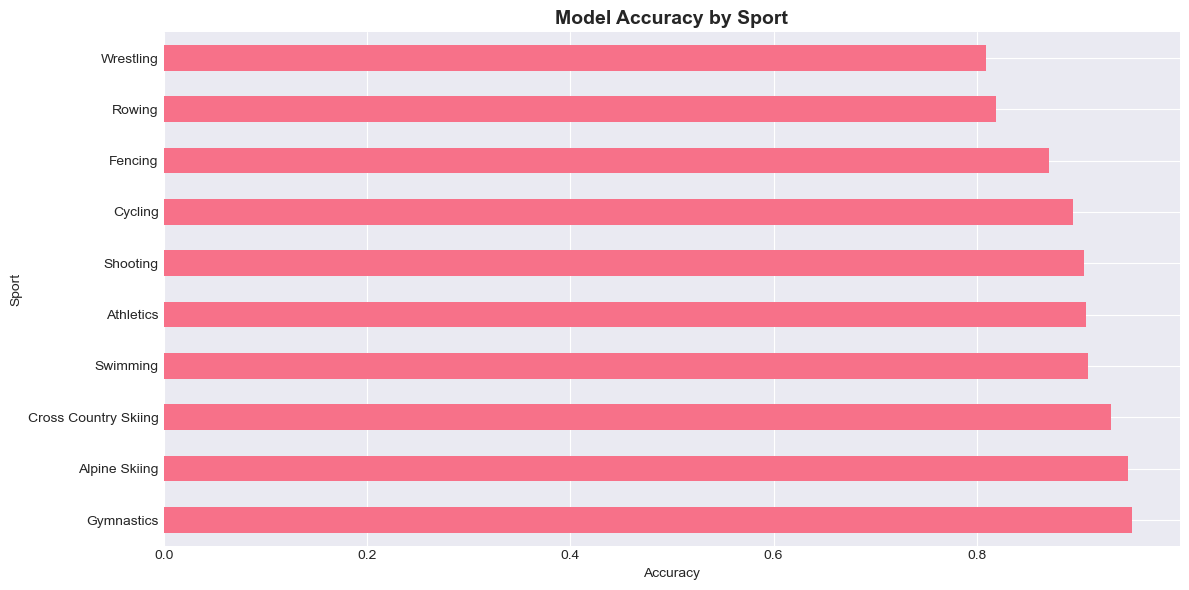

In [92]:
# Analyze predictions by different segments
test_results = X_test.copy()
test_results['Actual'] = y_test.values
test_results['Predicted'] = y_pred_final
test_results['Probability'] = y_pred_proba_final

# Add back categorical info for analysis
test_indices = test_results.index
test_results['Sport'] = df_processed.loc[test_indices, 'Sport'].values
test_results['Sex_Original'] = df_processed.loc[test_indices, 'Sex'].values
test_results['Season_Original'] = df_processed.loc[test_indices, 'Season'].values

# Accuracy by Sport (top sports)
top_sports_list = df['Sport'].value_counts().head(10).index
sport_accuracy = test_results[test_results['Sport'].isin(top_sports_list)].groupby('Sport').apply(
    lambda x: (x['Actual'] == x['Predicted']).mean()
).sort_values(ascending=False)

print("\nModel Accuracy by Sport (Top 10):")
print(sport_accuracy)

plt.figure(figsize=(12, 6))
sport_accuracy.plot(kind='barh')
plt.title('Model Accuracy by Sport', fontsize=14, fontweight='bold')
plt.xlabel('Accuracy')
plt.tight_layout()
plt.show()

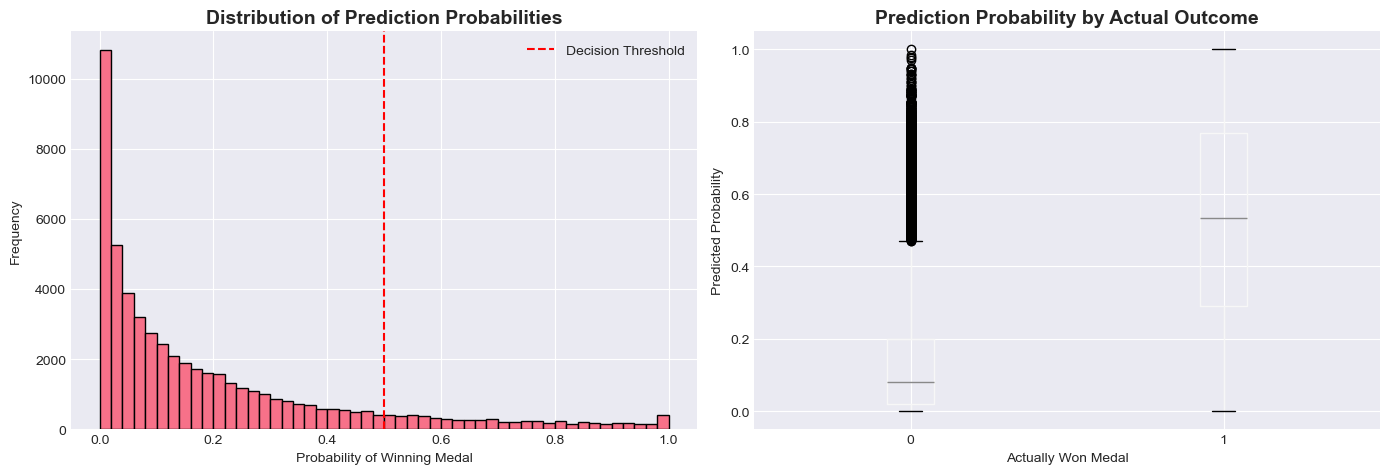


Prediction Confidence Summary:
Mean probability for actual medal winners: 0.5281
Mean probability for non-winners: 0.1375


In [94]:
# Prediction confidence analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution of prediction probabilities
axes[0].hist(test_results['Probability'], bins=50, edgecolor='black')
axes[0].set_title('Distribution of Prediction Probabilities', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Probability of Winning Medal')
axes[0].set_ylabel('Frequency')
axes[0].axvline(0.5, color='red', linestyle='--', label='Decision Threshold')
axes[0].legend()

# Probability by actual outcome
test_results.boxplot(column='Probability', by='Actual', ax=axes[1])
axes[1].set_title('Prediction Probability by Actual Outcome', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Actually Won Medal')
axes[1].set_ylabel('Predicted Probability')
plt.suptitle('')

plt.tight_layout()
plt.show()

# Calibration analysis
print("\nPrediction Confidence Summary:")
print(f"Mean probability for actual medal winners: {test_results[test_results['Actual']==1]['Probability'].mean():.4f}")
print(f"Mean probability for non-winners: {test_results[test_results['Actual']==0]['Probability'].mean():.4f}")

## 7. Key Findings and Limitations

### Key Findings:

1. **Most Important Predictors:**
   - Historical performance (previous medals, NOC/Sport/Event medal rates)
   - Experience (number of previous participations)
   - Sport-specific physical characteristics
   - Age relative to sport average

2. **Model Performance:**
   - Best model achieves reasonable predictive power
   - Better at identifying non-medal winners (high specificity)
   - Class imbalance handled through SMOTE

3. **Patterns Discovered:**
   - Historical success is highly predictive
   - Physical attributes vary significantly by sport
   - Experience matters but has diminishing returns

### Limitations:

1. **Data Limitations:**
   - Missing values in physical measurements (~9,500 rows)
   - No information on athlete's current form or injuries
   - No data on training, coaching, or resources
   - Competition dynamics not captured (strength of field)

2. **Model Limitations:**
   - Treats each participation as independent (ignores temporal patterns)
   - Cannot predict for completely new athletes with no history
   - High cardinality features (Team, NOC) only partially captured
   - Assumes historical patterns continue (Olympics evolve over time)

3. **Conceptual Limitations:**
   - Medals depend on many unobservable factors (motivation, luck, etc.)
   - Team events vs individual events have different dynamics
   - Political factors (boycotts, country participation) not accounted for

4. **Practical Limitations:**
   - Model trained on past data may not generalize to future Games
   - New sports and events require recalibration
   - Doesn't account for rule changes or technological advances

### Recommendations for Improvement:

1. Incorporate temporal features and time-series analysis
2. Add more contextual data (field strength, rankings, recent performance)
3. Use ensemble methods combining multiple model types
4. Consider hierarchical models by sport category
5. Collect more granular data on athlete preparation and condition

## 8. Conclusion

This project demonstrates that **predicting Olympic medal outcomes is possible with reasonable accuracy** using historical data and machine learning techniques. The model successfully identifies key factors that contribute to medal success:

- **Historical performance** is the strongest predictor
- **Experience** and previous success matter significantly
- **Physical attributes** are sport-specific
- **Country and sport contexts** provide important signals

However, Olympic performance involves many intangible factors that cannot be captured in historical data alone. The model serves as a useful tool for understanding patterns in Olympic success but should be interpreted with appropriate caution.

**Future work** could explore:
- Real-time data integration
- Sport-specific models
- Advanced feature engineering (athlete rankings, head-to-head records)
- Deep learning approaches for sequential data
- Uncertainty quantification in predictions

---
## End of Analysis
**Author:** Swaroop Kodagahalli Manjunathaswamy  
**Date:** February 13, 2026  
**Project:** Olympic Athletes Medal Prediction